# Data Science Study Part 2


Before solving problems, necessary libraries are imported as shown below.

In [56]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

#ignore warnings

os.environ["OMP_NUM_THREADS"] = "1"  # Limit MKL to using one thread

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message="KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads.")
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.neural_network._multilayer_perceptron')



## Problem 1

### EDA Process 

Data is imported.

In [57]:
filename="fitbit.csv"
df=pd.read_csv(filename)
display(df.head())

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,7/07/2016,"2,682","12,541",9.02,13,667,171,18,60,"1,248"
1,8/07/2016,"2,423","8,029",5.70,35,760,208,13,6,928
2,9/07/2016,"2,875","10,801",7.67,3,496,148,18,46,"1,040"
3,10/07/2016,"2,638","11,997",8.52,22,771,248,3,27,"1,285"
4,11/07/2016,"2,423","9,039",6.42,12,714,232,10,16,"1,044"


as stated in the question, the date field has also been removed from the data.

In [58]:
df.drop(columns=["Date"],inplace=True)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Calories Burned         30 non-null     object 
 1   Steps                   30 non-null     object 
 2   Distance                30 non-null     float64
 3   Floors                  30 non-null     int64  
 4   Minutes Sedentary       30 non-null     int64  
 5   Minutes Lightly Active  30 non-null     int64  
 6   Minutes Fairly Active   30 non-null     int64  
 7   Minutes Very Active     30 non-null     int64  
 8   Activity Calories       30 non-null     object 
dtypes: float64(1), int64(5), object(3)
memory usage: 2.2+ KB


None

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,"2,682","12,541",9.02,13,667,171,18,60,"1,248"
1,"2,423","8,029",5.70,35,760,208,13,6,928
2,"2,875","10,801",7.67,3,496,148,18,46,"1,040"
3,"2,638","11,997",8.52,22,771,248,3,27,"1,285"
4,"2,423","9,039",6.42,12,714,232,10,16,"1,044"


When the data is examined, it is observed that the comma is not a decimal separator. For example, the number of steps cannot be fractional. Therefore, the commas were removed. Additionally, when examining the data types, it is observed that fields that should be numbers are defined as objects due to the commas. Thus, the data type of the fields where the commas were removed has been changed to integer.

In [59]:
mod_columns=["Calories Burned","Steps","Activity Calories"]
for i in range(len(mod_columns)):
    df[mod_columns[i]] = df[mod_columns[i]].str.replace(',', '')
    df[mod_columns[i]] = df[mod_columns[i]].astype(int)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Calories Burned         30 non-null     int32  
 1   Steps                   30 non-null     int32  
 2   Distance                30 non-null     float64
 3   Floors                  30 non-null     int64  
 4   Minutes Sedentary       30 non-null     int64  
 5   Minutes Lightly Active  30 non-null     int64  
 6   Minutes Fairly Active   30 non-null     int64  
 7   Minutes Very Active     30 non-null     int64  
 8   Activity Calories       30 non-null     int32  
dtypes: float64(1), int32(3), int64(5)
memory usage: 1.9 KB


None

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2682,12541,9.02,13,667,171,18,60,1248
1,2423,8029,5.70,35,760,208,13,6,928
2,2875,10801,7.67,3,496,148,18,46,1040
3,2638,11997,8.52,22,771,248,3,27,1285
4,2423,9039,6.42,12,714,232,10,16,1044


Features (X) and target (y) is defined.

In [63]:
X = df.drop(columns=['Calories Burned'])
y = df['Calories Burned']

Column values are different from each other, for this reason we need to scale data.

In [64]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

Data is ready for task.

### Task:
First, using mutual information score find the top-4 features having the highest relationship with the
target ("calories burned" column).

Lets start with defining mutual information and ridge regression functions.

In [65]:
def mutual_inf(X,y,num_of_features):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)

    # Sort features are sorted by their score
    mi_scores = mi_scores.sort_values(ascending=False)
    top_features = mi_scores.head(num_of_features)
    return top_features

def ridge_reg(X,X_scaled,y,num_of_features):


    ridge = Ridge()

    # Instantiate RFE with Ridge as the estimator and number of features to select
    rfe = RFE(estimator=ridge, n_features_to_select=num_of_features)

    # Fit RFE. Scaled values are used.
    rfe.fit(X_scaled, y)

    # Get the mask of selected features
    selected_features = rfe.support_

    # Print the names of the top-4 features
    top_features = X.columns[selected_features]
    return top_features


Using the relevant functions, the top 4 features were determined and displayed in the expected format.

In [66]:
mi_features=mutual_inf(X,y,num_of_features=4)
ridge_features=ridge_reg(X,x_scaled,y,num_of_features=4)

print("Selected features having top mutual information scores")
print(list(mi_features.index))
print("Selected features by Recursive Feature Elimination")
print(list(ridge_features))

Selected features having top mutual information scores
['Activity Calories', 'Minutes Fairly Active', 'Steps', 'Distance']
Selected features by Recursive Feature Elimination
['Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Activity Calories']


- Both methods agree on the importance of 'Activity Calories' and 'Minutes Fairly Active'.
Mutual Information additionally highlights 'Steps' and 'Distance' as important features.
RFE highlights 'Minutes Sedentary' and 'Minutes Very Active' instead.
- These differences can occur because each method evaluates feature importance differently. Mutual Information measures the dependency between each feature and the target, while RFE uses a model-based approach to recursively select features that contribute most to the prediction accuracy. Combining insights from both methods can provide a more robust feature selection for model building.

## Problem 2

### EDA Process 

Firstly, data is imported.

In [32]:
filename="customer.csv"
df=pd.read_csv(filename)
display(df.head())

,ID,Visit.Time,Average.Expense,Sex,Age
0,1,3,5.7,0,10
1,2,5,14.5,0,27
2,3,16,33.5,0,32
3,4,5,15.9,0,30
4,5,16,24.9,0,23


as stated in the question, the date field has also been removed from the data.

In [33]:
df.drop(columns=['ID'],inplace=True)
display(df.head())
display(df.info())

,Visit.Time,Average.Expense,Sex,Age
0,3,5.7,0,10
1,5,14.5,0,27
2,16,33.5,0,32
3,5,15.9,0,30
4,16,24.9,0,23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Visit.Time       60 non-null     int64  
 1   Average.Expense  60 non-null     float64
 2   Sex              60 non-null     int64  
 3   Age              60 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 2.0 KB


None

As can be seen, the gender type is defined as integer even though it should be boolean. Therefore, the data type has been changed to object.

In [34]:
df['Sex'] = df['Sex'].astype("object")
display(df.head())
display(df.info())

,Visit.Time,Average.Expense,Sex,Age
0,3,5.7,0,10
1,5,14.5,0,27
2,16,33.5,0,32
3,5,15.9,0,30
4,16,24.9,0,23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Visit.Time       60 non-null     int64  
 1   Average.Expense  60 non-null     float64
 2   Sex              60 non-null     object 
 3   Age              60 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.0+ KB


None

Data is scaled.

In [35]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

Data is ready for task.

### Task:
Cluster customer information using K-means algorithm. Produce Elbow and silhouette
coefficient plots for cluster numbers ranging from 2 to 9.


In [40]:
def kmeans_alg(df_scaled):
    inertias = []
    silhouette_scores = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))
    return inertias,silhouette_scores




Silhouette scores and inertias are calculated and visualized.

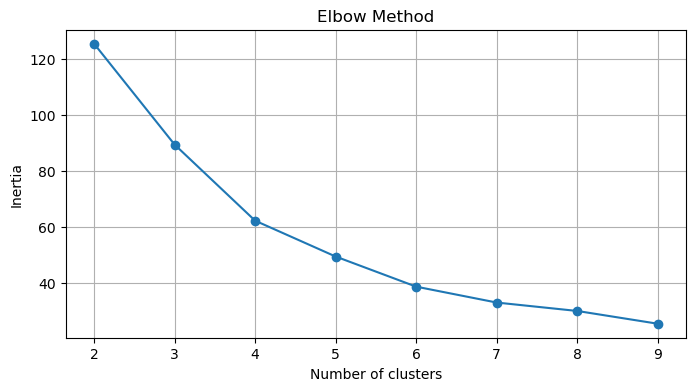

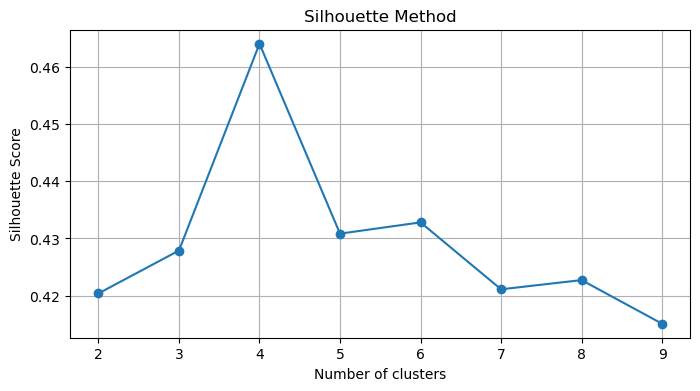

In [41]:
inertias,silhouette_scores=kmeans_alg(df_scaled)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In conclusion, both graphs suggest that the optimal number of clusters for the data is 4. The Elbow Method shows a clear elbow at 4 clusters, and the Silhouette Method has the highest silhouette score at 4 clusters. Therefore, 4 clusters appear to be the best choice for this dataset.

## Problem 3

### EDA Process

Data is imported.

In [43]:
filename="WA_Fn-UseC_-Telco-Customer-Churn.csv"
df=pd.read_csv(filename)
display(df.head())
display(df.info())

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

As it can be seen there are no null values. Additionally, In the dataset, there are some annotations that should be boolean but have similar meanings. For example, in the 'multiple lines' column, both 'no' and 'no phone service' are used. Therefore, let's examine the unique expressions column by column within the data. 

In [44]:
for i in range(len(df.columns)):
    print(df.columns[i],': ',df[df.columns[i]].unique())

customerID :  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender :  ['Female' 'Male']
SeniorCitizen :  [0 1]
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
tenure :  [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' 'Mail

The data in the decided columns has been reorganized to contain only 'yes' and 'no' values. Manipulated columns are shown below.

In [45]:
print('Transformed Features')
for i in range(len(df.columns)):
    
    before=len(df[df.columns[i]].unique())
    if 'No phone service' in df[df.columns[i]].unique():
        df[df.columns[i]]=df[df.columns[i]].replace('No phone service','No')
    if 'No internet service' in df[df.columns[i]].unique():
        df[df.columns[i]]=df[df.columns[i]].replace('No internet service','No')
    if 'DSL' in df[df.columns[i]].unique():
        df[df.columns[i]]=df[df.columns[i]].replace('DSL','Yes')
        df[df.columns[i]]=df[df.columns[i]].replace('Fiber optic','Yes')
    if len(df[df.columns[i]].unique()) != before:
        print(df.columns[i],': ',df[df.columns[i]].unique())

Transformed Features
MultipleLines :  ['No' 'Yes']
InternetService :  ['Yes' 'No']
OnlineSecurity :  ['No' 'Yes']
OnlineBackup :  ['Yes' 'No']
DeviceProtection :  ['No' 'Yes']
TechSupport :  ['No' 'Yes']
StreamingTV :  ['No' 'Yes']
StreamingMovies :  ['No' 'Yes']


### Task:
Predict customer churn with Logistic Regression, Decision Tree, Support Vector Machine, K-Nearest
Neighbor and Neural Network methods. For the parameters of these models use sklearn default
parameters. For cross-validation use 5-Fold cross validation with shuffling. When preparing the data
for prediction you can drop the customer ID. TotalCharges column has some missing data, drop the
rows having missing data in the totalcharges column. Print the average accuracy scores for training and
test splits of cross validation as given below. Note that you may get different scores since we use
shuffling the data in splitting step.

The 'Customer ID' column has been removed. Additionally, manipulations to remove any missing values were applied as stated in the question.

In [48]:
df.drop(columns=['customerID'], inplace=True)

df = df.dropna(subset=['TotalCharges'])
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

features and targets are defined. Moreover features are modified for One-hot encoding for categorical features.

In [49]:
X = df.drop(columns=['Churn'])
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


X = pd.get_dummies(X)

Expected inputs and models are defined.

In [50]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Neural Network": MLPClassifier()
}

results = {}

Models are executed as it shown below.

In [55]:
for model_name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize the data
        ('classifier', model)
    ])
    
    # Compute cross-validated scores for training and test sets
    train_scores = []
    test_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        
        train_scores.append(pipeline.score(X_train, y_train))
        test_scores.append(pipeline.score(X_test, y_test))

    results[model_name] = {
        "train_score": np.mean(train_scores),
        "test_score": np.mean(test_scores)
    }


Results are reported.

In [53]:
result_df = pd.DataFrame({
    'model': results.keys(),
    'train': [scores['train_score'] for scores in results.values()],
    'test': [scores['test_score'] for scores in results.values()]
})

result_df.set_index('model', inplace=True)
print(result_df)

                           train      test
model                                     
Logistic Regression     0.805390  0.802900
Decision Tree           0.997831  0.724257
Support Vector Machine  0.822881  0.793800
K-Nearest Neighbors     0.828641  0.751847
Neural Network          0.870058  0.773321


Logistic Regression and Support Vector Machine appear to be the best models in terms of generalization to unseen data, with very close train and test accuracies. In additionally, Logistic Regression having a slight edge due to its slightly higher test accuracy.